In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from scipy.spatial import distance

import spacv

In [2]:
# load the dataset for obesity prevalence prediction

df_obesity = pd.read_csv("../Data/Obesity/Obesity.csv")
df_obesity[["GEOID"]] = df_obesity[["GEOID"]].astype(str)
y = df_obesity['obesity_cr']
df_obesity.shape

(1995, 25)

In [3]:
using_columns = ['% Black','% Ame Indi and AK Native','% Asian','% Nati Hawa and Paci Island','% Hispanic or Latino','% male',
                 '% married','% age 18-29','% age 30-39','% age 40-49','% age 50-59','% age >=60','% <highschool',
                 'median income','% unemployment','% below poverty line','% food stamp/SNAP','median value units built',
                 'median year units built','% renter-occupied housing units','population density']
num_features = len(using_columns)
num_features

21

In [4]:
# Load the census tract shapefile of NYC

boundary = gpd.read_file("../Data/Obesity/NYC_CDC data_Tract_Ob_pro.shp")
boundary = boundary.to_crs("EPSG:4326")

In [5]:
# Create the geodataframe for the data

gdf_obesity = gpd.GeoDataFrame(df_obesity, geometry=gpd.points_from_xy(df_obesity['Lonpro'], df_obesity['Latpro']))

In [6]:
# Standardization function

def standarize_data(data, stats):
    return (data - stats['mean'])/ stats['std']

## Random CV

In [8]:
# random split

y_dnn_socio_predict = []
y_true = []

ten_fold = KFold(n_splits=10, shuffle=True, random_state=42)

i = 1

for train_index, test_index in ten_fold.split(df_obesity):
    print("fold:", str(i))
    X_train, X_test = df_obesity.iloc[train_index], df_obesity.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = X_train[using_columns]
    X_test = X_test[using_columns]
    
    training_stat = X_train.describe().transpose()
    scaled_X_train = standarize_data(X_train, training_stat)
    scaled_X_test = standarize_data(X_test, training_stat)

    tf.random.set_seed(42)
    
    dnn_model = keras.models.Sequential([
        keras.layers.Dense(160,activation="relu"),
        keras.layers.Dense(208,activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(160,activation="relu"),
        keras.layers.Dense(160,activation="relu"),
        keras.layers.Dense(256,activation="relu"),
        keras.layers.Dense(32,activation="relu"),
        keras.layers.Dense(240,activation="relu"),
        keras.layers.Dense(96,activation="relu"),
        keras.layers.Dense(208,activation="relu"),
        keras.layers.Dense(1)
    ])
    
    dnn_model.compile(optimizer="adam", loss=keras.losses.mean_squared_error, metrics=[keras.metrics.mean_squared_error])
    dnn_model.fit(x=scaled_X_train, y=y_train, epochs=50, verbose=2)
    
    this_y_predict = dnn_model.predict(scaled_X_test).flatten()
    y_dnn_socio_predict = y_dnn_socio_predict + this_y_predict.tolist()
    y_true = y_true + y_test.tolist()
    
    i = i + 1

fold: 1
Epoch 1/50
57/57 - 2s - loss: 205.7457 - mean_squared_error: 205.7457 - 2s/epoch - 30ms/step
Epoch 2/50
57/57 - 0s - loss: 27.7060 - mean_squared_error: 27.7060 - 189ms/epoch - 3ms/step
Epoch 3/50
57/57 - 0s - loss: 18.5817 - mean_squared_error: 18.5817 - 180ms/epoch - 3ms/step
Epoch 4/50
57/57 - 0s - loss: 12.3072 - mean_squared_error: 12.3072 - 181ms/epoch - 3ms/step
Epoch 5/50
57/57 - 0s - loss: 10.2900 - mean_squared_error: 10.2900 - 184ms/epoch - 3ms/step
Epoch 6/50
57/57 - 0s - loss: 8.1042 - mean_squared_error: 8.1042 - 155ms/epoch - 3ms/step
Epoch 7/50
57/57 - 0s - loss: 7.1581 - mean_squared_error: 7.1581 - 184ms/epoch - 3ms/step
Epoch 8/50
57/57 - 0s - loss: 5.6014 - mean_squared_error: 5.6014 - 167ms/epoch - 3ms/step
Epoch 9/50
57/57 - 0s - loss: 5.7138 - mean_squared_error: 5.7138 - 166ms/epoch - 3ms/step
Epoch 10/50
57/57 - 0s - loss: 5.3743 - mean_squared_error: 5.3743 - 182ms/epoch - 3ms/step
Epoch 11/50
57/57 - 0s - loss: 4.5523 - mean_squared_error: 4.5523 - 18

Epoch 40/50
57/57 - 0s - loss: 1.6913 - mean_squared_error: 1.6913 - 185ms/epoch - 3ms/step
Epoch 41/50
57/57 - 0s - loss: 1.6718 - mean_squared_error: 1.6718 - 182ms/epoch - 3ms/step
Epoch 42/50
57/57 - 0s - loss: 1.4440 - mean_squared_error: 1.4440 - 180ms/epoch - 3ms/step
Epoch 43/50
57/57 - 0s - loss: 1.3244 - mean_squared_error: 1.3244 - 182ms/epoch - 3ms/step
Epoch 44/50
57/57 - 0s - loss: 1.4890 - mean_squared_error: 1.4890 - 202ms/epoch - 4ms/step
Epoch 45/50
57/57 - 0s - loss: 1.2690 - mean_squared_error: 1.2690 - 200ms/epoch - 4ms/step
Epoch 46/50
57/57 - 0s - loss: 1.3391 - mean_squared_error: 1.3391 - 216ms/epoch - 4ms/step
Epoch 47/50
57/57 - 0s - loss: 1.6197 - mean_squared_error: 1.6197 - 200ms/epoch - 4ms/step
Epoch 48/50
57/57 - 0s - loss: 1.7540 - mean_squared_error: 1.7540 - 200ms/epoch - 4ms/step
Epoch 49/50
57/57 - 0s - loss: 1.5113 - mean_squared_error: 1.5113 - 192ms/epoch - 3ms/step
Epoch 50/50
57/57 - 0s - loss: 1.3552 - mean_squared_error: 1.3552 - 182ms/epoch

Epoch 28/50
57/57 - 0s - loss: 1.8688 - mean_squared_error: 1.8688 - 184ms/epoch - 3ms/step
Epoch 29/50
57/57 - 0s - loss: 2.1082 - mean_squared_error: 2.1082 - 186ms/epoch - 3ms/step
Epoch 30/50
57/57 - 0s - loss: 1.8481 - mean_squared_error: 1.8481 - 183ms/epoch - 3ms/step
Epoch 31/50
57/57 - 0s - loss: 1.7474 - mean_squared_error: 1.7474 - 171ms/epoch - 3ms/step
Epoch 32/50
57/57 - 0s - loss: 1.7757 - mean_squared_error: 1.7757 - 195ms/epoch - 3ms/step
Epoch 33/50
57/57 - 0s - loss: 1.6522 - mean_squared_error: 1.6522 - 170ms/epoch - 3ms/step
Epoch 34/50
57/57 - 0s - loss: 2.1287 - mean_squared_error: 2.1287 - 169ms/epoch - 3ms/step
Epoch 35/50
57/57 - 0s - loss: 1.7881 - mean_squared_error: 1.7881 - 182ms/epoch - 3ms/step
Epoch 36/50
57/57 - 0s - loss: 1.5316 - mean_squared_error: 1.5316 - 184ms/epoch - 3ms/step
Epoch 37/50
57/57 - 0s - loss: 1.5886 - mean_squared_error: 1.5886 - 184ms/epoch - 3ms/step
Epoch 38/50
57/57 - 0s - loss: 1.4501 - mean_squared_error: 1.4501 - 182ms/epoch

Epoch 16/50
57/57 - 0s - loss: 3.4253 - mean_squared_error: 3.4253 - 179ms/epoch - 3ms/step
Epoch 17/50
57/57 - 0s - loss: 3.5791 - mean_squared_error: 3.5791 - 172ms/epoch - 3ms/step
Epoch 18/50
57/57 - 0s - loss: 2.9015 - mean_squared_error: 2.9015 - 194ms/epoch - 3ms/step
Epoch 19/50
57/57 - 0s - loss: 2.9039 - mean_squared_error: 2.9039 - 195ms/epoch - 3ms/step
Epoch 20/50
57/57 - 0s - loss: 3.0763 - mean_squared_error: 3.0763 - 166ms/epoch - 3ms/step
Epoch 21/50
57/57 - 0s - loss: 2.6295 - mean_squared_error: 2.6295 - 185ms/epoch - 3ms/step
Epoch 22/50
57/57 - 0s - loss: 2.7106 - mean_squared_error: 2.7106 - 188ms/epoch - 3ms/step
Epoch 23/50
57/57 - 0s - loss: 2.2851 - mean_squared_error: 2.2851 - 203ms/epoch - 4ms/step
Epoch 24/50
57/57 - 0s - loss: 2.2683 - mean_squared_error: 2.2683 - 170ms/epoch - 3ms/step
Epoch 25/50
57/57 - 0s - loss: 2.4845 - mean_squared_error: 2.4845 - 173ms/epoch - 3ms/step
Epoch 26/50
57/57 - 0s - loss: 2.6153 - mean_squared_error: 2.6153 - 196ms/epoch

Epoch 4/50
57/57 - 0s - loss: 10.6242 - mean_squared_error: 10.6242 - 190ms/epoch - 3ms/step
Epoch 5/50
57/57 - 0s - loss: 10.3983 - mean_squared_error: 10.3983 - 196ms/epoch - 3ms/step
Epoch 6/50
57/57 - 0s - loss: 7.1025 - mean_squared_error: 7.1025 - 193ms/epoch - 3ms/step
Epoch 7/50
57/57 - 0s - loss: 6.3903 - mean_squared_error: 6.3903 - 194ms/epoch - 3ms/step
Epoch 8/50
57/57 - 0s - loss: 5.7990 - mean_squared_error: 5.7990 - 190ms/epoch - 3ms/step
Epoch 9/50
57/57 - 0s - loss: 6.9456 - mean_squared_error: 6.9456 - 175ms/epoch - 3ms/step
Epoch 10/50
57/57 - 0s - loss: 4.4774 - mean_squared_error: 4.4774 - 190ms/epoch - 3ms/step
Epoch 11/50
57/57 - 0s - loss: 4.2965 - mean_squared_error: 4.2965 - 163ms/epoch - 3ms/step
Epoch 12/50
57/57 - 0s - loss: 4.2033 - mean_squared_error: 4.2033 - 174ms/epoch - 3ms/step
Epoch 13/50
57/57 - 0s - loss: 3.2946 - mean_squared_error: 3.2946 - 174ms/epoch - 3ms/step
Epoch 14/50
57/57 - 0s - loss: 3.4391 - mean_squared_error: 3.4391 - 174ms/epoch -

Epoch 43/50
57/57 - 0s - loss: 1.4147 - mean_squared_error: 1.4147 - 166ms/epoch - 3ms/step
Epoch 44/50
57/57 - 0s - loss: 1.8386 - mean_squared_error: 1.8386 - 166ms/epoch - 3ms/step
Epoch 45/50
57/57 - 0s - loss: 2.1715 - mean_squared_error: 2.1715 - 165ms/epoch - 3ms/step
Epoch 46/50
57/57 - 0s - loss: 1.6791 - mean_squared_error: 1.6791 - 168ms/epoch - 3ms/step
Epoch 47/50
57/57 - 0s - loss: 1.5305 - mean_squared_error: 1.5305 - 188ms/epoch - 3ms/step
Epoch 48/50
57/57 - 0s - loss: 1.3116 - mean_squared_error: 1.3116 - 180ms/epoch - 3ms/step
Epoch 49/50
57/57 - 0s - loss: 1.2143 - mean_squared_error: 1.2143 - 174ms/epoch - 3ms/step
Epoch 50/50
57/57 - 0s - loss: 1.5817 - mean_squared_error: 1.5817 - 168ms/epoch - 3ms/step
7/7 [==============================] - 0s 2ms/step
fold: 10
Epoch 1/50
57/57 - 2s - loss: 192.2079 - mean_squared_error: 192.2079 - 2s/epoch - 32ms/step
Epoch 2/50
57/57 - 0s - loss: 27.6232 - mean_squared_error: 27.6232 - 210ms/epoch - 4ms/step
Epoch 3/50
57/57 -

In [9]:
dnn_socio_rmse = mean_squared_error(y_true , y_dnn_socio_predict, squared=False)
dnn_socio_r2 = r2_score(y_true, y_dnn_socio_predict)
print("rmse: " + str(round(dnn_socio_rmse,4)), "r2: " + str(round(dnn_socio_r2,4)))

rmse: 2.1599 r2: 0.8653


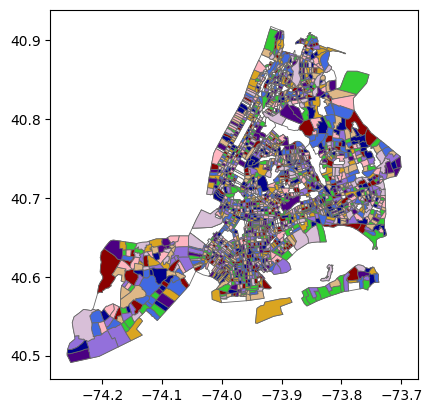

In [10]:
# figure for spatial CV

fig, ax = plt.subplots(nrows=1, ncols=1)
basemap = boundary.plot(ax=ax, color='white', edgecolor='dimgrey', linewidth=0.6)
color_list = ['darkred', 'goldenrod', 'limegreen', 'burlywood', 'royalblue', 'mediumpurple', 'lightpink', 'thistle', 'indigo', 'darkblue']

i=0
for train_index, test_index in ten_fold.split(df_obesity):  
    test_index = df_obesity.iloc[test_index]["GEOID"].astype(str).to_list()
    test_geometry = boundary.loc[boundary["GEOID"].isin(test_index)]
    test_geometry.plot(ax=basemap, color=color_list[i], edgecolor='dimgrey', linewidth=0.6)    
    i = i + 1

plt.savefig('../Data/Obesity/Figs/random.png', dpi=300)
plt.show()

## Clustering-based spatial CV

C:\Users\sunk\anaconda3\envs\spaCV\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


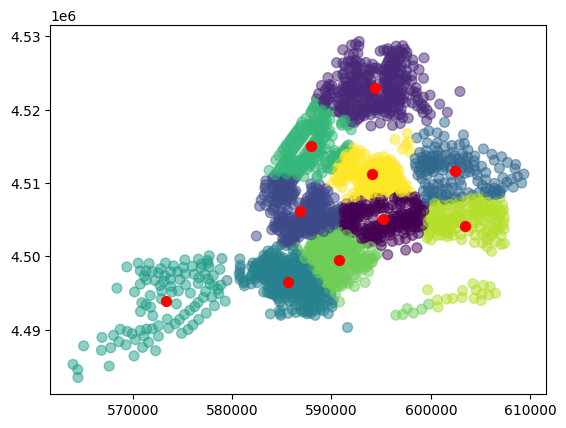

In [11]:
# Split the data based on their coordinates using k-means clustering algorithm

kmeans = KMeans(n_clusters=10, random_state=42).fit(df_obesity[['Lonpro','Latpro']])
centroids = kmeans.cluster_centers_

plt.scatter(df_obesity['Lonpro'], df_obesity['Latpro'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

In [12]:
# label the cluster index of each sample. 

df_obesity_cluster = df_obesity.copy()
df_obesity_cluster["cluster"] = kmeans.labels_.tolist()
df_obesity_cluster["cluster"].value_counts()

cluster
1    301
4    269
2    239
7    215
6    191
0    190
8    170
9    170
3    147
5    103
Name: count, dtype: int64

In [13]:
y_dnn_socio_predict = []
y_true = []

group_index = df_obesity_cluster['cluster'].values

group_kfold = GroupKFold(n_splits=10)

i = 1

for train_index, test_index in group_kfold.split(df_obesity_cluster, y, group_index):
    print("fold:", str(i))

    X_train, X_test = df_obesity.iloc[train_index], df_obesity.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = X_train[using_columns]
    X_test = X_test[using_columns]
    
    training_stat = X_train.describe().transpose()
    scaled_X_train = standarize_data(X_train, training_stat)
    scaled_X_test = standarize_data(X_test, training_stat)

    tf.random.set_seed(42)
    
    dnn_model = keras.models.Sequential([
        keras.layers.Dense(160,activation="relu"),
        keras.layers.Dense(208,activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(160,activation="relu"),
        keras.layers.Dense(160,activation="relu"),
        keras.layers.Dense(256,activation="relu"),
        keras.layers.Dense(32,activation="relu"),
        keras.layers.Dense(240,activation="relu"),
        keras.layers.Dense(96,activation="relu"),
        keras.layers.Dense(208,activation="relu"),
        keras.layers.Dense(1)
    ])
    
    dnn_model.compile(optimizer="adam", loss=keras.losses.mean_squared_error, metrics=[keras.metrics.mean_squared_error])
    dnn_model.fit(x=scaled_X_train, y=y_train, epochs=50,   verbose=2)
    
    this_y_predict = dnn_model.predict(scaled_X_test).flatten()
    y_dnn_socio_predict = y_dnn_socio_predict + this_y_predict.tolist()
    y_true = y_true + y_test.tolist()
    
    i = i + 1    

fold: 1
Epoch 1/50
53/53 - 2s - loss: 161.1380 - mean_squared_error: 161.1380 - 2s/epoch - 29ms/step
Epoch 2/50
53/53 - 0s - loss: 24.5083 - mean_squared_error: 24.5083 - 182ms/epoch - 3ms/step
Epoch 3/50
53/53 - 0s - loss: 16.1274 - mean_squared_error: 16.1274 - 184ms/epoch - 3ms/step
Epoch 4/50
53/53 - 0s - loss: 11.3341 - mean_squared_error: 11.3341 - 182ms/epoch - 3ms/step
Epoch 5/50
53/53 - 0s - loss: 8.7197 - mean_squared_error: 8.7197 - 184ms/epoch - 3ms/step
Epoch 6/50
53/53 - 0s - loss: 7.0687 - mean_squared_error: 7.0687 - 191ms/epoch - 4ms/step
Epoch 7/50
53/53 - 0s - loss: 5.8641 - mean_squared_error: 5.8641 - 179ms/epoch - 3ms/step
Epoch 8/50
53/53 - 0s - loss: 4.7683 - mean_squared_error: 4.7683 - 179ms/epoch - 3ms/step
Epoch 9/50
53/53 - 0s - loss: 4.5293 - mean_squared_error: 4.5293 - 178ms/epoch - 3ms/step
Epoch 10/50
53/53 - 0s - loss: 4.3172 - mean_squared_error: 4.3172 - 183ms/epoch - 3ms/step
Epoch 11/50
53/53 - 0s - loss: 3.6065 - mean_squared_error: 3.6065 - 202m

Epoch 40/50
54/54 - 0s - loss: 1.3672 - mean_squared_error: 1.3672 - 168ms/epoch - 3ms/step
Epoch 41/50
54/54 - 0s - loss: 1.6040 - mean_squared_error: 1.6040 - 173ms/epoch - 3ms/step
Epoch 42/50
54/54 - 0s - loss: 1.5529 - mean_squared_error: 1.5529 - 169ms/epoch - 3ms/step
Epoch 43/50
54/54 - 0s - loss: 1.7260 - mean_squared_error: 1.7260 - 170ms/epoch - 3ms/step
Epoch 44/50
54/54 - 0s - loss: 1.4137 - mean_squared_error: 1.4137 - 168ms/epoch - 3ms/step
Epoch 45/50
54/54 - 0s - loss: 1.3409 - mean_squared_error: 1.3409 - 168ms/epoch - 3ms/step
Epoch 46/50
54/54 - 0s - loss: 1.1049 - mean_squared_error: 1.1049 - 175ms/epoch - 3ms/step
Epoch 47/50
54/54 - 0s - loss: 1.2073 - mean_squared_error: 1.2073 - 180ms/epoch - 3ms/step
Epoch 48/50
54/54 - 0s - loss: 1.4802 - mean_squared_error: 1.4802 - 173ms/epoch - 3ms/step
Epoch 49/50
54/54 - 0s - loss: 1.1770 - mean_squared_error: 1.1770 - 182ms/epoch - 3ms/step
Epoch 50/50
54/54 - 0s - loss: 1.2805 - mean_squared_error: 1.2805 - 198ms/epoch

Epoch 28/50
56/56 - 0s - loss: 2.1031 - mean_squared_error: 2.1031 - 172ms/epoch - 3ms/step
Epoch 29/50
56/56 - 0s - loss: 1.8909 - mean_squared_error: 1.8909 - 170ms/epoch - 3ms/step
Epoch 30/50
56/56 - 0s - loss: 2.0730 - mean_squared_error: 2.0730 - 179ms/epoch - 3ms/step
Epoch 31/50
56/56 - 0s - loss: 2.0175 - mean_squared_error: 2.0175 - 184ms/epoch - 3ms/step
Epoch 32/50
56/56 - 0s - loss: 1.7233 - mean_squared_error: 1.7233 - 182ms/epoch - 3ms/step
Epoch 33/50
56/56 - 0s - loss: 1.5632 - mean_squared_error: 1.5632 - 182ms/epoch - 3ms/step
Epoch 34/50
56/56 - 0s - loss: 1.5719 - mean_squared_error: 1.5719 - 180ms/epoch - 3ms/step
Epoch 35/50
56/56 - 0s - loss: 1.5860 - mean_squared_error: 1.5860 - 183ms/epoch - 3ms/step
Epoch 36/50
56/56 - 0s - loss: 1.3551 - mean_squared_error: 1.3551 - 182ms/epoch - 3ms/step
Epoch 37/50
56/56 - 0s - loss: 1.5569 - mean_squared_error: 1.5569 - 184ms/epoch - 3ms/step
Epoch 38/50
56/56 - 0s - loss: 1.6619 - mean_squared_error: 1.6619 - 181ms/epoch

Epoch 16/50
57/57 - 0s - loss: 3.2176 - mean_squared_error: 3.2176 - 205ms/epoch - 4ms/step
Epoch 17/50
57/57 - 0s - loss: 2.9180 - mean_squared_error: 2.9180 - 195ms/epoch - 3ms/step
Epoch 18/50
57/57 - 0s - loss: 2.7327 - mean_squared_error: 2.7327 - 204ms/epoch - 4ms/step
Epoch 19/50
57/57 - 0s - loss: 3.2326 - mean_squared_error: 3.2326 - 199ms/epoch - 3ms/step
Epoch 20/50
57/57 - 0s - loss: 2.6884 - mean_squared_error: 2.6884 - 180ms/epoch - 3ms/step
Epoch 21/50
57/57 - 0s - loss: 2.5373 - mean_squared_error: 2.5373 - 210ms/epoch - 4ms/step
Epoch 22/50
57/57 - 0s - loss: 2.4737 - mean_squared_error: 2.4737 - 197ms/epoch - 3ms/step
Epoch 23/50
57/57 - 0s - loss: 2.3858 - mean_squared_error: 2.3858 - 198ms/epoch - 3ms/step
Epoch 24/50
57/57 - 0s - loss: 2.6151 - mean_squared_error: 2.6151 - 197ms/epoch - 3ms/step
Epoch 25/50
57/57 - 0s - loss: 2.0282 - mean_squared_error: 2.0282 - 196ms/epoch - 3ms/step
Epoch 26/50
57/57 - 0s - loss: 2.2252 - mean_squared_error: 2.2252 - 193ms/epoch

Epoch 4/50
58/58 - 0s - loss: 11.9652 - mean_squared_error: 11.9652 - 194ms/epoch - 3ms/step
Epoch 5/50
58/58 - 0s - loss: 10.9857 - mean_squared_error: 10.9857 - 170ms/epoch - 3ms/step
Epoch 6/50
58/58 - 0s - loss: 8.3972 - mean_squared_error: 8.3972 - 165ms/epoch - 3ms/step
Epoch 7/50
58/58 - 0s - loss: 6.7894 - mean_squared_error: 6.7894 - 189ms/epoch - 3ms/step
Epoch 8/50
58/58 - 0s - loss: 6.0656 - mean_squared_error: 6.0656 - 182ms/epoch - 3ms/step
Epoch 9/50
58/58 - 0s - loss: 5.3029 - mean_squared_error: 5.3029 - 188ms/epoch - 3ms/step
Epoch 10/50
58/58 - 0s - loss: 5.0172 - mean_squared_error: 5.0172 - 199ms/epoch - 3ms/step
Epoch 11/50
58/58 - 0s - loss: 5.8623 - mean_squared_error: 5.8623 - 216ms/epoch - 4ms/step
Epoch 12/50
58/58 - 0s - loss: 3.9392 - mean_squared_error: 3.9392 - 175ms/epoch - 3ms/step
Epoch 13/50
58/58 - 0s - loss: 4.9068 - mean_squared_error: 4.9068 - 197ms/epoch - 3ms/step
Epoch 14/50
58/58 - 0s - loss: 3.6586 - mean_squared_error: 3.6586 - 177ms/epoch -

Epoch 43/50
58/58 - 0s - loss: 1.2235 - mean_squared_error: 1.2235 - 182ms/epoch - 3ms/step
Epoch 44/50
58/58 - 0s - loss: 1.1784 - mean_squared_error: 1.1784 - 168ms/epoch - 3ms/step
Epoch 45/50
58/58 - 0s - loss: 1.3096 - mean_squared_error: 1.3096 - 165ms/epoch - 3ms/step
Epoch 46/50
58/58 - 0s - loss: 1.2588 - mean_squared_error: 1.2588 - 174ms/epoch - 3ms/step
Epoch 47/50
58/58 - 0s - loss: 1.4965 - mean_squared_error: 1.4965 - 172ms/epoch - 3ms/step
Epoch 48/50
58/58 - 0s - loss: 1.3115 - mean_squared_error: 1.3115 - 179ms/epoch - 3ms/step
Epoch 49/50
58/58 - 0s - loss: 1.4925 - mean_squared_error: 1.4925 - 181ms/epoch - 3ms/step
Epoch 50/50
58/58 - 0s - loss: 1.2436 - mean_squared_error: 1.2436 - 176ms/epoch - 3ms/step
5/5 [==============================] - 0s 6ms/step
fold: 10
Epoch 1/50
60/60 - 2s - loss: 147.7852 - mean_squared_error: 147.7852 - 2s/epoch - 28ms/step
Epoch 2/50
60/60 - 0s - loss: 23.0780 - mean_squared_error: 23.0780 - 231ms/epoch - 4ms/step
Epoch 3/50
60/60 -

In [14]:
dnn_socio_rmse = mean_squared_error(y_true , y_dnn_socio_predict, squared=False)
dnn_socio_r2 = r2_score(y_true, y_dnn_socio_predict)
print("rmse: " + str(round(dnn_socio_rmse,4)), "r2: " + str(round(dnn_socio_r2,4)))

rmse: 2.9273 r2: 0.7526


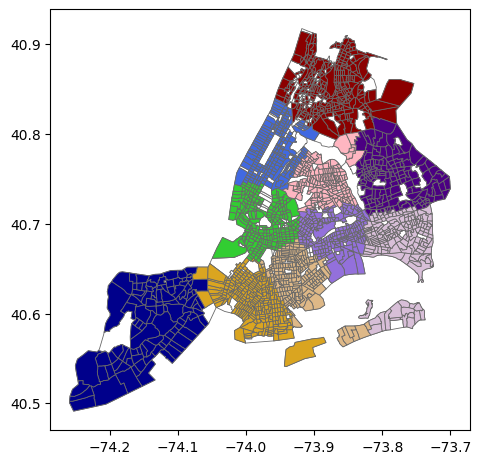

In [15]:
# Making a figure for cluster based spatial CV

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.tight_layout()
basemap = boundary.plot(ax=ax, color='white', edgecolor='dimgrey', linewidth=0.6)

i=0
color_list = ['darkred', 'goldenrod', 'limegreen', 'burlywood', 'royalblue', 'mediumpurple', 'lightpink', 'thistle', 'indigo', 'darkblue']
for train_index, test_index in group_kfold.split(df_obesity_cluster, y, group_index):  
    test_index = df_obesity.iloc[test_index]["GEOID"].astype(str).to_list()
    test_geometry = boundary.loc[boundary["GEOID"].isin(test_index)]
    test_geometry.plot(ax=basemap, color=color_list[i], edgecolor='dimgrey', linewidth=0.6)    
    i = i + 1

plt.savefig('../Data/Obesity/Figs/cluster.png', dpi=300)
plt.show()

## Grid-based spatial CV

In [20]:
grid_cv = spacv.HBLOCK(3, 3, method='unique', buffer_radius=0).split(gdf_obesity['geometry'])

In [17]:
y_dnn_socio_predict = []
y_true = []

i = 1

for train_index, test_index in grid_cv:
    print("fold:", str(i))

    X_train, X_test = df_obesity.iloc[train_index], df_obesity.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = X_train[using_columns]
    X_test = X_test[using_columns]
    
    training_stat = X_train.describe().transpose()
    scaled_X_train = standarize_data(X_train, training_stat)
    scaled_X_test = standarize_data(X_test, training_stat)

    tf.random.set_seed(42)
    
    dnn_model = keras.models.Sequential([
        keras.layers.Dense(160,activation="relu"),
        keras.layers.Dense(208,activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(160,activation="relu"),
        keras.layers.Dense(160,activation="relu"),
        keras.layers.Dense(256,activation="relu"),
        keras.layers.Dense(32,activation="relu"),
        keras.layers.Dense(240,activation="relu"),
        keras.layers.Dense(96,activation="relu"),
        keras.layers.Dense(208,activation="relu"),
        keras.layers.Dense(1)
    ])
    
    dnn_model.compile(optimizer="adam", loss=keras.losses.mean_squared_error, metrics=[keras.metrics.mean_squared_error])
    dnn_model.fit(x=scaled_X_train, y=y_train, epochs=50,   verbose=2)
    
    this_y_predict = dnn_model.predict(scaled_X_test).flatten()
    y_dnn_socio_predict = y_dnn_socio_predict + this_y_predict.tolist()
    y_true = y_true + y_test.tolist()
    
    i = i + 1

fold: 1
Epoch 1/50


C:\Users\sunk\anaconda3\envs\spaCV\lib\site-packages\spacv\base_classes.py:46: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  for test_indices, train_excluded in self._iter_test_indices(XYs):


60/60 - 2s - loss: 186.2292 - mean_squared_error: 186.2292 - 2s/epoch - 27ms/step
Epoch 2/50
60/60 - 0s - loss: 24.8847 - mean_squared_error: 24.8847 - 208ms/epoch - 3ms/step
Epoch 3/50
60/60 - 0s - loss: 16.3627 - mean_squared_error: 16.3627 - 202ms/epoch - 3ms/step
Epoch 4/50
60/60 - 0s - loss: 11.0467 - mean_squared_error: 11.0467 - 199ms/epoch - 3ms/step
Epoch 5/50
60/60 - 0s - loss: 8.7355 - mean_squared_error: 8.7355 - 203ms/epoch - 3ms/step
Epoch 6/50
60/60 - 0s - loss: 7.4635 - mean_squared_error: 7.4635 - 204ms/epoch - 3ms/step
Epoch 7/50
60/60 - 0s - loss: 5.8143 - mean_squared_error: 5.8143 - 231ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 4.6508 - mean_squared_error: 4.6508 - 223ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 4.3335 - mean_squared_error: 4.3335 - 217ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 3.9753 - mean_squared_error: 3.9753 - 218ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 3.8124 - mean_squared_error: 3.8124 - 302ms/epoch - 5ms/step


Epoch 40/50
54/54 - 0s - loss: 1.4557 - mean_squared_error: 1.4557 - 165ms/epoch - 3ms/step
Epoch 41/50
54/54 - 0s - loss: 1.6740 - mean_squared_error: 1.6740 - 164ms/epoch - 3ms/step
Epoch 42/50
54/54 - 0s - loss: 1.5764 - mean_squared_error: 1.5764 - 176ms/epoch - 3ms/step
Epoch 43/50
54/54 - 0s - loss: 1.5032 - mean_squared_error: 1.5032 - 170ms/epoch - 3ms/step
Epoch 44/50
54/54 - 0s - loss: 1.6537 - mean_squared_error: 1.6537 - 170ms/epoch - 3ms/step
Epoch 45/50
54/54 - 0s - loss: 1.2735 - mean_squared_error: 1.2735 - 177ms/epoch - 3ms/step
Epoch 46/50
54/54 - 0s - loss: 1.2823 - mean_squared_error: 1.2823 - 182ms/epoch - 3ms/step
Epoch 47/50
54/54 - 0s - loss: 1.3320 - mean_squared_error: 1.3320 - 175ms/epoch - 3ms/step
Epoch 48/50
54/54 - 0s - loss: 1.2000 - mean_squared_error: 1.2000 - 176ms/epoch - 3ms/step
Epoch 49/50
54/54 - 0s - loss: 1.1918 - mean_squared_error: 1.1918 - 171ms/epoch - 3ms/step
Epoch 50/50
54/54 - 0s - loss: 1.2282 - mean_squared_error: 1.2282 - 171ms/epoch

Epoch 28/50
63/63 - 0s - loss: 2.1157 - mean_squared_error: 2.1157 - 223ms/epoch - 4ms/step
Epoch 29/50
63/63 - 0s - loss: 1.9983 - mean_squared_error: 1.9983 - 199ms/epoch - 3ms/step
Epoch 30/50
63/63 - 0s - loss: 2.2362 - mean_squared_error: 2.2362 - 198ms/epoch - 3ms/step
Epoch 31/50
63/63 - 0s - loss: 1.8545 - mean_squared_error: 1.8545 - 200ms/epoch - 3ms/step
Epoch 32/50
63/63 - 0s - loss: 1.5497 - mean_squared_error: 1.5497 - 199ms/epoch - 3ms/step
Epoch 33/50
63/63 - 0s - loss: 1.5699 - mean_squared_error: 1.5699 - 198ms/epoch - 3ms/step
Epoch 34/50
63/63 - 0s - loss: 1.6344 - mean_squared_error: 1.6344 - 194ms/epoch - 3ms/step
Epoch 35/50
63/63 - 0s - loss: 1.6017 - mean_squared_error: 1.6017 - 194ms/epoch - 3ms/step
Epoch 36/50
63/63 - 0s - loss: 1.8241 - mean_squared_error: 1.8241 - 196ms/epoch - 3ms/step
Epoch 37/50
63/63 - 0s - loss: 1.7394 - mean_squared_error: 1.7394 - 195ms/epoch - 3ms/step
Epoch 38/50
63/63 - 0s - loss: 1.7255 - mean_squared_error: 1.7255 - 196ms/epoch

Epoch 16/50
48/48 - 0s - loss: 3.9256 - mean_squared_error: 3.9256 - 174ms/epoch - 4ms/step
Epoch 17/50
48/48 - 0s - loss: 3.3900 - mean_squared_error: 3.3900 - 185ms/epoch - 4ms/step
Epoch 18/50
48/48 - 0s - loss: 2.7847 - mean_squared_error: 2.7847 - 187ms/epoch - 4ms/step
Epoch 19/50
48/48 - 0s - loss: 2.7481 - mean_squared_error: 2.7481 - 166ms/epoch - 3ms/step
Epoch 20/50
48/48 - 0s - loss: 2.8305 - mean_squared_error: 2.8305 - 179ms/epoch - 4ms/step
Epoch 21/50
48/48 - 0s - loss: 2.7063 - mean_squared_error: 2.7063 - 350ms/epoch - 7ms/step
Epoch 22/50
48/48 - 0s - loss: 2.7603 - mean_squared_error: 2.7603 - 188ms/epoch - 4ms/step
Epoch 23/50
48/48 - 0s - loss: 2.3641 - mean_squared_error: 2.3641 - 165ms/epoch - 3ms/step
Epoch 24/50
48/48 - 0s - loss: 2.2853 - mean_squared_error: 2.2853 - 152ms/epoch - 3ms/step
Epoch 25/50
48/48 - 0s - loss: 2.3209 - mean_squared_error: 2.3209 - 166ms/epoch - 3ms/step
Epoch 26/50
48/48 - 0s - loss: 1.8761 - mean_squared_error: 1.8761 - 172ms/epoch

Epoch 4/50
57/57 - 0s - loss: 12.1224 - mean_squared_error: 12.1224 - 167ms/epoch - 3ms/step
Epoch 5/50
57/57 - 0s - loss: 9.2666 - mean_squared_error: 9.2666 - 182ms/epoch - 3ms/step
Epoch 6/50
57/57 - 0s - loss: 7.7204 - mean_squared_error: 7.7204 - 184ms/epoch - 3ms/step
Epoch 7/50
57/57 - 0s - loss: 6.4079 - mean_squared_error: 6.4079 - 199ms/epoch - 3ms/step
Epoch 8/50
57/57 - 0s - loss: 6.3532 - mean_squared_error: 6.3532 - 185ms/epoch - 3ms/step
Epoch 9/50
57/57 - 0s - loss: 5.4087 - mean_squared_error: 5.4087 - 198ms/epoch - 3ms/step
Epoch 10/50
57/57 - 0s - loss: 4.6944 - mean_squared_error: 4.6944 - 185ms/epoch - 3ms/step
Epoch 11/50
57/57 - 0s - loss: 4.3470 - mean_squared_error: 4.3470 - 183ms/epoch - 3ms/step
Epoch 12/50
57/57 - 0s - loss: 4.2736 - mean_squared_error: 4.2736 - 185ms/epoch - 3ms/step
Epoch 13/50
57/57 - 0s - loss: 3.5814 - mean_squared_error: 3.5814 - 182ms/epoch - 3ms/step
Epoch 14/50
57/57 - 0s - loss: 3.4764 - mean_squared_error: 3.4764 - 200ms/epoch - 4

In [18]:
dnn_socio_rmse = mean_squared_error(y_true , y_dnn_socio_predict, squared=False)
dnn_socio_r2 = r2_score(y_true, y_dnn_socio_predict)
print("rmse: " + str(round(dnn_socio_rmse,4)), "r2: " + str(round(dnn_socio_r2,4)))

rmse: 2.9475 r2: 0.7492


C:\Users\sunk\anaconda3\envs\spaCV\lib\site-packages\spacv\base_classes.py:46: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  for test_indices, train_excluded in self._iter_test_indices(XYs):


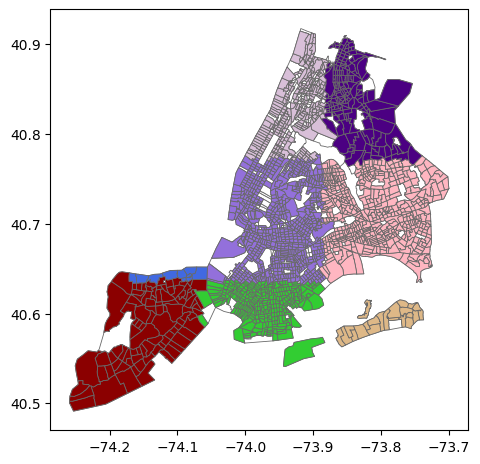

In [21]:
# Making a figure for grid based CV

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.tight_layout()
basemap = boundary.plot(ax=ax, color='white', edgecolor='dimgrey', linewidth=0.6)

i=0
color_list = ['darkred', 'limegreen', 'burlywood', 'royalblue', 'mediumpurple', 'lightpink', 'thistle', 'indigo', 'darkblue']
for train_index, test_index in grid_cv:  
    test_index = df_obesity.iloc[test_index]["GEOID"].astype(str).to_list()
    test_geometry = boundary.loc[boundary["GEOID"].isin(test_index)]
    test_geometry.plot(ax=basemap, color=color_list[i], edgecolor='dimgrey', linewidth=0.6)    
    i = i + 1

plt.savefig('../Data/Obesity/Figs/grid.png', dpi=300)
plt.show()

## Geo-attribute-based spatial CV

In [22]:
# load the file for showing which borough each census tract is located in.

gdf_tract_borough = gpd.read_file("../Data/Obesity/gdf_tract_borough.shp")

In [23]:
df_obesity_block = df_obesity.merge(gdf_tract_borough[['GEOID','index_righ']], how='left', left_on="GEOID", right_on="GEOID")
df_obesity_block.head()

,GEOID,% Black,% Ame Indi and AK Native,% Asian,% Nati Hawa and Paci Island,% Hispanic or Latino,% male,% married,% age 18-29,% age 30-39,...,% below poverty line,% food stamp/SNAP,median value units built,median year units built,% renter-occupied housing units,population density,Lonpro,Latpro,obesity_cr,index_righ
0,36081046200,0.128637,0.001426,0.405733,0.000000,0.324729,0.429122,0.443847,0.207074,0.149173,...,0.086140,0.167808,566100,1964,0.776419,28106.912090,602380.0,4507260.0,26.6,4.0
1,36081045000,0.078431,0.000000,0.579115,0.000000,0.191518,0.447788,0.534483,0.176015,0.133151,...,0.071591,0.076923,585500,1939,0.326454,12744.813160,600955.0,4507720.0,19.6,4.0
2,36081045400,0.160195,0.008653,0.628800,0.000000,0.101176,0.526514,0.550474,0.151986,0.135123,...,0.147992,0.089735,168400,1954,0.558124,19521.893370,601697.0,4507560.0,21.5,4.0
3,36081045600,0.028744,0.000000,0.708775,0.000000,0.142209,0.486384,0.604982,0.216339,0.116490,...,0.170197,0.201201,650900,1939,0.279279,8153.246497,601862.0,4508000.0,18.6,4.0
4,36081044602,0.197928,0.011224,0.427585,0.016836,0.298295,0.462335,0.505800,0.136844,0.189294,...,0.325225,0.340757,281000,1957,0.869339,27255.666740,601380.0,4507060.0,30.6,4.0


In [24]:
df_obesity_block.index_righ.nunique()

5

In [25]:
y_dnn_socio_predict = []
y_true = []

block = df_obesity_block['index_righ'].values
group_kfold = GroupKFold(n_splits=5)

i = 1

for train_index, test_index in group_kfold.split(df_obesity_block, y, block):
    print("fold:", str(i))

    X_train, X_test = df_obesity.iloc[train_index], df_obesity.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = X_train[using_columns]
    X_test = X_test[using_columns]
    
    training_stat = X_train.describe().transpose()
    scaled_X_train = standarize_data(X_train, training_stat)
    scaled_X_test = standarize_data(X_test, training_stat)

    tf.random.set_seed(42)
    
    dnn_model = keras.models.Sequential([
        keras.layers.Dense(160,activation="relu"),
        keras.layers.Dense(208,activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(160,activation="relu"),
        keras.layers.Dense(160,activation="relu"),
        keras.layers.Dense(256,activation="relu"),
        keras.layers.Dense(32,activation="relu"),
        keras.layers.Dense(240,activation="relu"),
        keras.layers.Dense(96,activation="relu"),
        keras.layers.Dense(208,activation="relu"),
        keras.layers.Dense(1)
    ])
    
    dnn_model.compile(optimizer="adam", loss=keras.losses.mean_squared_error, metrics=[keras.metrics.mean_squared_error])
    dnn_model.fit(x=scaled_X_train, y=y_train, epochs=50,   verbose=2)
    
    this_y_predict = dnn_model.predict(scaled_X_test).flatten()

    y_dnn_socio_predict = y_dnn_socio_predict + this_y_predict.tolist()
    y_true = y_true + y_test.tolist()
    
    i = i + 1

fold: 1
Epoch 1/50
40/40 - 2s - loss: 237.9176 - mean_squared_error: 237.9176 - 2s/epoch - 39ms/step
Epoch 2/50
40/40 - 0s - loss: 31.6711 - mean_squared_error: 31.6711 - 150ms/epoch - 4ms/step
Epoch 3/50
40/40 - 0s - loss: 22.1551 - mean_squared_error: 22.1551 - 159ms/epoch - 4ms/step
Epoch 4/50
40/40 - 0s - loss: 16.4353 - mean_squared_error: 16.4353 - 137ms/epoch - 3ms/step
Epoch 5/50
40/40 - 0s - loss: 13.1013 - mean_squared_error: 13.1013 - 148ms/epoch - 4ms/step
Epoch 6/50
40/40 - 0s - loss: 10.6478 - mean_squared_error: 10.6478 - 250ms/epoch - 6ms/step
Epoch 7/50
40/40 - 0s - loss: 9.2518 - mean_squared_error: 9.2518 - 157ms/epoch - 4ms/step
Epoch 8/50
40/40 - 0s - loss: 8.1064 - mean_squared_error: 8.1064 - 123ms/epoch - 3ms/step
Epoch 9/50
40/40 - 0s - loss: 6.6402 - mean_squared_error: 6.6402 - 114ms/epoch - 3ms/step
Epoch 10/50
40/40 - 0s - loss: 6.3879 - mean_squared_error: 6.3879 - 116ms/epoch - 3ms/step
Epoch 11/50
40/40 - 0s - loss: 5.4700 - mean_squared_error: 5.4700 - 

Epoch 40/50
43/43 - 0s - loss: 1.4874 - mean_squared_error: 1.4874 - 152ms/epoch - 4ms/step
Epoch 41/50
43/43 - 0s - loss: 1.3435 - mean_squared_error: 1.3435 - 150ms/epoch - 3ms/step
Epoch 42/50
43/43 - 0s - loss: 1.1747 - mean_squared_error: 1.1747 - 131ms/epoch - 3ms/step
Epoch 43/50
43/43 - 0s - loss: 1.2063 - mean_squared_error: 1.2063 - 153ms/epoch - 4ms/step
Epoch 44/50
43/43 - 0s - loss: 1.2385 - mean_squared_error: 1.2385 - 150ms/epoch - 3ms/step
Epoch 45/50
43/43 - 0s - loss: 1.1885 - mean_squared_error: 1.1885 - 168ms/epoch - 4ms/step
Epoch 46/50
43/43 - 0s - loss: 1.3467 - mean_squared_error: 1.3467 - 125ms/epoch - 3ms/step
Epoch 47/50
43/43 - 0s - loss: 1.2369 - mean_squared_error: 1.2369 - 133ms/epoch - 3ms/step
Epoch 48/50
43/43 - 0s - loss: 1.2155 - mean_squared_error: 1.2155 - 141ms/epoch - 3ms/step
Epoch 49/50
43/43 - 0s - loss: 1.2992 - mean_squared_error: 1.2992 - 146ms/epoch - 3ms/step
Epoch 50/50
43/43 - 0s - loss: 1.1039 - mean_squared_error: 1.1039 - 138ms/epoch

Epoch 28/50
55/55 - 0s - loss: 1.9338 - mean_squared_error: 1.9338 - 183ms/epoch - 3ms/step
Epoch 29/50
55/55 - 0s - loss: 1.8570 - mean_squared_error: 1.8570 - 185ms/epoch - 3ms/step
Epoch 30/50
55/55 - 0s - loss: 2.0773 - mean_squared_error: 2.0773 - 172ms/epoch - 3ms/step
Epoch 31/50
55/55 - 0s - loss: 2.0170 - mean_squared_error: 2.0170 - 178ms/epoch - 3ms/step
Epoch 32/50
55/55 - 0s - loss: 1.9437 - mean_squared_error: 1.9437 - 187ms/epoch - 3ms/step
Epoch 33/50
55/55 - 0s - loss: 1.8971 - mean_squared_error: 1.8971 - 180ms/epoch - 3ms/step
Epoch 34/50
55/55 - 0s - loss: 1.5460 - mean_squared_error: 1.5460 - 183ms/epoch - 3ms/step
Epoch 35/50
55/55 - 0s - loss: 1.4691 - mean_squared_error: 1.4691 - 183ms/epoch - 3ms/step
Epoch 36/50
55/55 - 0s - loss: 1.9387 - mean_squared_error: 1.9387 - 170ms/epoch - 3ms/step
Epoch 37/50
55/55 - 0s - loss: 1.5603 - mean_squared_error: 1.5603 - 182ms/epoch - 3ms/step
Epoch 38/50
55/55 - 0s - loss: 1.7234 - mean_squared_error: 1.7234 - 183ms/epoch

In [26]:
dnn_socio_rmse = mean_squared_error(y_true , y_dnn_socio_predict, squared=False)
dnn_socio_r2 = r2_score(y_true, y_dnn_socio_predict)
print("rmse: " + str(round(dnn_socio_rmse,4)), "r2: " + str(round(dnn_socio_r2,4)))

rmse: 3.6263 r2: 0.6204


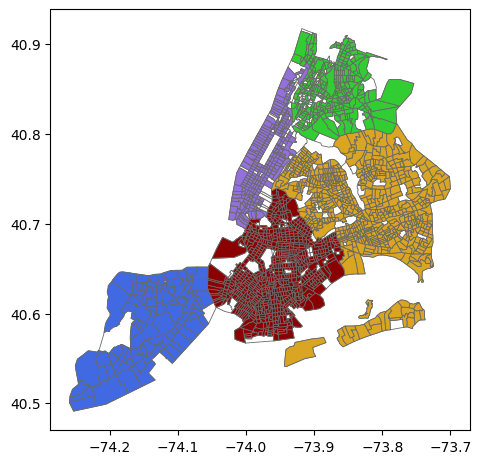

In [18]:
# Making a figure for geo-attribute based spatial CV

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.tight_layout()
basemap = boundary.plot(ax=ax, color='white', edgecolor='dimgrey', linewidth=0.6)

i = 0
color_list = ['darkred', 'goldenrod', 'limegreen', 'mediumpurple', 'royalblue']
for train_index, test_index in group_kfold.split(df_obesity_block, y, block):  
    test_index = df_obesity.iloc[test_index]["GEOID"].astype(str).to_list()
    test_geometry = boundary.loc[boundary["GEOID"].isin(test_index)]
    test_geometry.plot(ax=basemap, color=color_list[i], edgecolor='dimgrey', linewidth=0.6)    
    i = i + 1

plt.savefig('../Data/Obesity/Figs/geo.png', dpi=300)
plt.show()

## Spatial leave-one-out CV

In [8]:
# Compute the radius of buffer as the 0.05 quantile of distances of data

from itertools import combinations

lng_lat_coords = np.array(df_obesity[['Lonpro','Latpro']])

distances = [distance.euclidean(p1, p2) for p1, p2 in combinations(lng_lat_coords, 2)]
distances_array=np.array(distances)
radius = int(np.quantile(distances_array, 0.05))
radius

3219

In [9]:
# Split the training and test data for each fold using the buffer_radius

skcv = spacv.SKCV(n_splits=1995, buffer_radius=radius, random_state=42).split(gdf_obesity['geometry'])

In [ ]:
y_dnn_socio_predict = []
y_true = []

i = 1

for train_index, test_index in skcv:
    print("fold:", str(i))
    X_train, X_test = df_obesity.iloc[train_index], df_obesity.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = X_train[using_columns]
    X_test = X_test[using_columns]
    
    training_stat = X_train.describe().transpose()
    scaled_X_train = standarize_data(X_train, training_stat)
    scaled_X_test = standarize_data(X_test, training_stat)

    tf.random.set_seed(42)
    
    dnn_model = keras.models.Sequential([
        keras.layers.Dense(160,activation="relu"),
        keras.layers.Dense(208,activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(160,activation="relu"),
        keras.layers.Dense(160,activation="relu"),
        keras.layers.Dense(256,activation="relu"),
        keras.layers.Dense(32,activation="relu"),
        keras.layers.Dense(240,activation="relu"),
        keras.layers.Dense(96,activation="relu"),
        keras.layers.Dense(208,activation="relu"),
        keras.layers.Dense(1)
    ])
    
    dnn_model.compile(optimizer="adam", loss=keras.losses.mean_squared_error, metrics=[keras.metrics.mean_squared_error])
    dnn_model.fit(x=scaled_X_train, y=y_train, epochs=50, verbose=2)
    
    this_y_predict = dnn_model.predict(scaled_X_test).flatten()
    y_dnn_socio_predict = y_dnn_socio_predict + this_y_predict.tolist()
    y_true = y_true + y_test.tolist()
    
    i = i + 1

In [ ]:
dnn_socio_rmse = mean_squared_error(y_true , y_dnn_socio_predict, squared=False)
dnn_socio_r2 = r2_score(y_true, y_dnn_socio_predict)
print("rmse: " + str(round(dnn_socio_rmse,4)), "r2: " + str(round(dnn_socio_r2,4)))

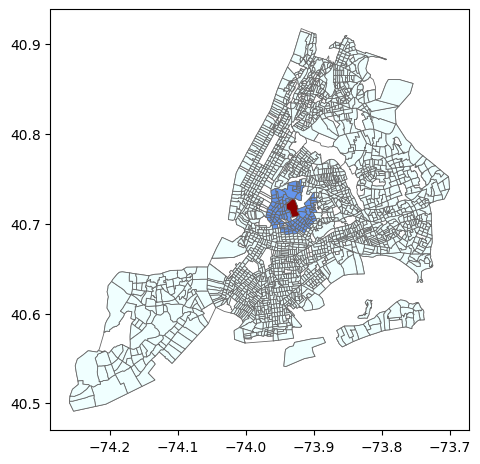

In [10]:
# Make a figure for sloo

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.tight_layout()
basemap = boundary.plot(ax=ax, color='white', edgecolor='dimgrey', linewidth=0.6)

i = 0
for train_index, test_index in skcv:  
    test_index = df_obesity.iloc[test_index]["GEOID"].astype(str).to_list()
    
    # Taking one census tract of "36047044900" as the example of test sample.
    if test_index[0] != "36047044900":
        continue    
    
    train_index = df_obesity.iloc[train_index]["GEOID"].astype(str).to_list()
    train_exclued = list(set(df_obesity['GEOID'].astype(str).tolist())-set(train_index)-set(test_index))
        
    test_geometry = boundary.loc[boundary["GEOID"].isin(test_index)]
    train_geometry = boundary.loc[boundary["GEOID"].isin(train_index)]
    train_exclued_geometry = boundary.loc[boundary["GEOID"].isin(train_exclued)]
    testmap = test_geometry.plot(ax=basemap, color='darkred', edgecolor='dimgrey', linewidth=0.6)
    trainmap = train_geometry.plot(ax=testmap, color='azure', edgecolor='dimgrey', linewidth=0.6)
    train_exclued_geometry.plot(ax=trainmap, color='cornflowerblue', edgecolor='dimgrey', linewidth=0.6)
    
    break

plt.savefig('../Data/Obesity/Figs/sloo.png', dpi=300)
plt.show()